In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import copy
import tqdm

%matplotlib inline

In [0]:
# to observe consistent results
torch.manual_seed(999)
torch.cuda.manual_seed(999)

In [0]:
# aply transforms to return img as tensor type
train_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
])

test_transform = transforms.Compose([
  transforms.ToTensor()
])

# make train & test dataset
train_dataset = torchvision.datasets.FashionMNIST('Fashion-MNIST/processed/training.pt', train=True, download=True, transform = train_transform)
test_dataset = torchvision.datasets.FashionMNIST('Fashion-MNIST/processed/test.pt', train=False, download = True, transform = test_transform)

num_classes = len(train_dataset.classes)

0it [00:00, ?it/s]

26427392it [00:01, 13876066.38it/s]                             


Extracting Fashion-MNIST/processed/training.pt/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 96258.30it/s]                            
0it [00:00, ?it/s]

Extracting Fashion-MNIST/processed/training.pt/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 4016863.65it/s]                             
0it [00:00, ?it/s]

Extracting Fashion-MNIST/processed/training.pt/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 29416.58it/s]            
0it [00:00, ?it/s]

Extracting Fashion-MNIST/processed/training.pt/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


26427392it [00:01, 14507413.41it/s]                             


Extracting Fashion-MNIST/processed/test.pt/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 93874.96it/s]                            
0it [00:00, ?it/s]

Extracting Fashion-MNIST/processed/test.pt/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 4116571.11it/s]                             
0it [00:00, ?it/s]

Extracting Fashion-MNIST/processed/test.pt/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 20118.14it/s]            

Extracting Fashion-MNIST/processed/test.pt/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
# make dataloader
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False, num_workers=4)

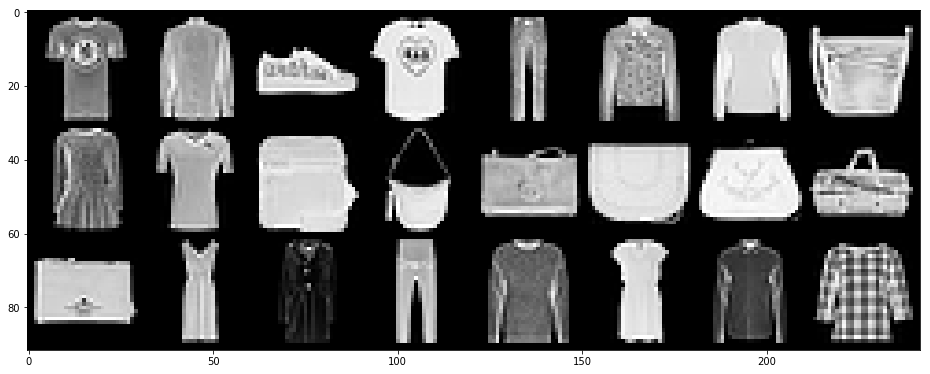

In [0]:
# check data loader works well
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

## Task1
- Implement FC Model & LeNet-5
- Train and test two networks

In [0]:
# simple Fully Connected Network
class FCNet(nn.Module):
  def __init__(self, num_classes):
    super(FCNet, self).__init__()
    # just 4 hidden fully connected layers
    self.linear1 = nn.Sequential(
        nn.Linear(1*28*28, 1000),
        nn.ReLU()
    )
    self.linear2 = nn.Sequential(
        nn.Linear(1000, 500),
        nn.ReLU()
    )
    self.linear3 = nn.Sequential(
        nn.Linear(500, 100),
        nn.ReLU()
    )
    self.fc = nn.Linear(100, num_classes)
  def forward(self, x):
    # consider batch size
    x = x.view(-1, 1*28*28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.fc(x)
    return x

In [0]:
# LeNet5 structure
class LeNet5(nn.Module):
  def __init__(self, num_classes):
    super(LeNet5, self).__init__()
    # 6 @ 28x28
    self.conv1 = nn.Sequential(
        # Lenet's first conv layer is 3x32x32, squeeze color channels into 1 and pad 2
        nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size =2, stride = 2)
    )
    # 16 @ 10x10
    self.conv2 = nn.Sequential(
        nn.Conv2d(6, 16, kernel_size =5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size =2, stride = 2)
    )
    
    self.fc1 = nn.Sequential(
        nn.Linear(16*5*5, 120),
        nn.ReLU()
    )
    self.fc2 = nn.Sequential(
        nn.Linear(120, 84),
        nn.ReLU()
    )
    self.classifier = nn.Linear(84, num_classes)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(-1, 16*5*5)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.classifier(x)
    return x
    

In [0]:
model = dict()
model['fc'] = FCNet(num_classes)
model['le'] = LeNet5(num_classes)

In [0]:
# function which calculates accuracy
def accuracy(output, labels):
  pred = torch.argmax(output, dim=1)
  correct = pred.eq(labels)
  return torch.mean(correct.float())

In [0]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [0]:
# define hyper params
model['fc'] = model['fc'].to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model['fc'].parameters(), lr=0.002)

total_loss, total_acc = 0,0
loss_list = []
acc_list = []

epochs = 20
itr = 1
p_itr = 200

# start training
model['fc'].train()
for epoch in range(epochs):
  for samples, labels in train_loader:
    samples, labels = samples.to(device), labels.to(device)
    optimizer.zero_grad()
    output = model['fc'](samples)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    total_acc += accuracy(output, labels)
    
    if itr%p_itr == 0:
      print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_acc/p_itr))
      loss_list.append(total_loss/p_itr)
      acc_list.append(total_acc/p_itr)
      total_loss, total_acc = 0,0
    itr+=1
      

[Epoch 1/20] Iteration 200 -> Train Loss: 2.2973, Accuracy: 0.117
[Epoch 1/20] Iteration 400 -> Train Loss: 2.2859, Accuracy: 0.193
[Epoch 2/20] Iteration 600 -> Train Loss: 2.2741, Accuracy: 0.225
[Epoch 2/20] Iteration 800 -> Train Loss: 2.2587, Accuracy: 0.251
[Epoch 3/20] Iteration 1000 -> Train Loss: 2.2404, Accuracy: 0.285
[Epoch 3/20] Iteration 1200 -> Train Loss: 2.2170, Accuracy: 0.324
[Epoch 3/20] Iteration 1400 -> Train Loss: 2.1875, Accuracy: 0.342
[Epoch 4/20] Iteration 1600 -> Train Loss: 2.1507, Accuracy: 0.363
[Epoch 4/20] Iteration 1800 -> Train Loss: 2.0996, Accuracy: 0.385
[Epoch 5/20] Iteration 2000 -> Train Loss: 2.0369, Accuracy: 0.409
[Epoch 5/20] Iteration 2200 -> Train Loss: 1.9622, Accuracy: 0.449
[Epoch 6/20] Iteration 2400 -> Train Loss: 1.8706, Accuracy: 0.482
[Epoch 6/20] Iteration 2600 -> Train Loss: 1.7630, Accuracy: 0.519
[Epoch 6/20] Iteration 2800 -> Train Loss: 1.6505, Accuracy: 0.541
[Epoch 7/20] Iteration 3000 -> Train Loss: 1.5361, Accuracy: 0.555

In [0]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(loss_list, label='fc_loss', color = 'g')
ax2.plot(acc_list, label='fc_accuracy', color = 'b')
ax1.set_ylabel('loss')
ax2.set_ylabel('accuracy')
plt.title('FC Net training loss and accuracy')
plt.show()

In [0]:
# test 
model['fc'].eval()
test_acc = 0.0
for samples, labels in test_loader:
    with torch.no_grad():
        samples, labels = samples.to(device), labels.to(device)
        output = model['fc'](samples)
        test_acc += accuracy(output, labels)
    
print('Accuracy of the network on {} test images: {}%'.format(len(test_dataset), round(test_acc.item()*100.0/len(test_loader), 2)))

Accuracy of the network on 10000 test images: 72.46%


In [0]:
# define hyper params
model['le'] = model['le'].to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model['le'].parameters(), lr=0.002)

total_loss, total_acc = 0,0
loss_list = []
acc_list = []

epochs = 20
itr = 1
p_itr = 200

# start training
model['le'].train()
for epoch in range(epochs):
  for samples, labels in train_loader:
    samples, labels = samples.to(device), labels.to(device)
    optimizer.zero_grad()
    output = model['le'](samples)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    total_acc += accuracy(output, labels)
    
    if itr%p_itr == 0:
      print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_acc/p_itr))
      loss_list.append(total_loss/p_itr)
      acc_list.append(total_acc/p_itr)
      total_loss, total_acc = 0,0
    itr+=1
      

[Epoch 1/20] Iteration 200 -> Train Loss: 2.3034, Accuracy: 0.114
[Epoch 1/20] Iteration 400 -> Train Loss: 2.3024, Accuracy: 0.124
[Epoch 2/20] Iteration 600 -> Train Loss: 2.3014, Accuracy: 0.127
[Epoch 2/20] Iteration 800 -> Train Loss: 2.3007, Accuracy: 0.129
[Epoch 3/20] Iteration 1000 -> Train Loss: 2.2999, Accuracy: 0.137
[Epoch 3/20] Iteration 1200 -> Train Loss: 2.2986, Accuracy: 0.151
[Epoch 3/20] Iteration 1400 -> Train Loss: 2.2979, Accuracy: 0.160
[Epoch 4/20] Iteration 1600 -> Train Loss: 2.2963, Accuracy: 0.195
[Epoch 4/20] Iteration 1800 -> Train Loss: 2.2944, Accuracy: 0.222
[Epoch 5/20] Iteration 2000 -> Train Loss: 2.2916, Accuracy: 0.261
[Epoch 5/20] Iteration 2200 -> Train Loss: 2.2888, Accuracy: 0.287
[Epoch 6/20] Iteration 2400 -> Train Loss: 2.2843, Accuracy: 0.295
[Epoch 6/20] Iteration 2600 -> Train Loss: 2.2794, Accuracy: 0.284
[Epoch 6/20] Iteration 2800 -> Train Loss: 2.2712, Accuracy: 0.298
[Epoch 7/20] Iteration 3000 -> Train Loss: 2.2584, Accuracy: 0.324

In [0]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(loss_list, label='lenet_loss', color = 'g')
ax2.plot(acc_list, label='lenet_accuracy', color = 'b')
ax1.set_ylabel('loss')
ax2.set_ylabel('accuracy')

plt.title('LeNet training loss and accuracy')
plt.show()

In [0]:
# test
model['le'].eval()
test_acc = 0.0
for samples, labels in test_loader:
    with torch.no_grad():
        samples, labels = samples.to(device), labels.to(device)
        output = model['le'](samples)
        test_acc += accuracy(output, labels)
    
print('Accuracy of the network on {} test images: {}%'.format(len(test_dataset), round(test_acc.item()*100.0/len(test_loader),2)))

Accuracy of the network on 10000 test images: 74.18%


## Task2
- Analyze the elements of training process
- Loss function, optimizer, learning rate, batchsize etc

start!!!


batch_size: 128 | learning_rate: 0.01 | loss_function: Cross Entropy | optimizer: Adam
Accuracy of the network on 10000 test images: 88.34%



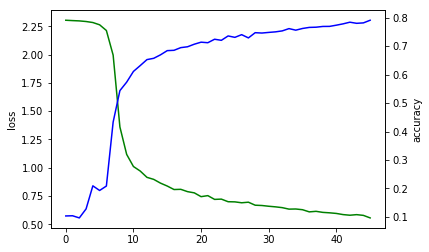

batch_size: 128 | learning_rate: 0.01 | loss_function: Cross Entropy | optimizer: SGD
Accuracy of the network on 10000 test images: 77.29%



batch_size: 128 | learning_rate: 0.01 | loss_function: Multi Hinge | optimizer: Adam
Accuracy of the network on 10000 test images: 87.92%



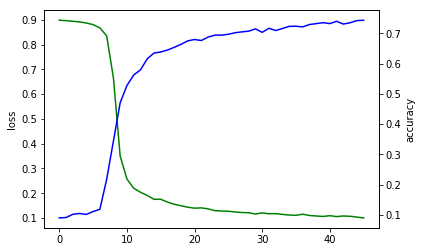

batch_size: 128 | learning_rate: 0.01 | loss_function: Multi Hinge | optimizer: SGD
Accuracy of the network on 10000 test images: 74.1%



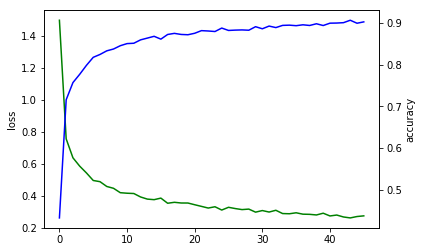

batch_size: 128 | learning_rate: 0.001 | loss_function: Cross Entropy | optimizer: Adam
Accuracy of the network on 10000 test images: 88.93%



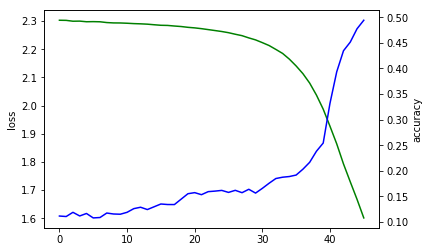

batch_size: 128 | learning_rate: 0.001 | loss_function: Cross Entropy | optimizer: SGD
Accuracy of the network on 10000 test images: 53.46%



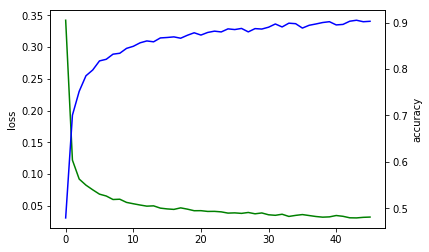

batch_size: 128 | learning_rate: 0.001 | loss_function: Multi Hinge | optimizer: Adam
Accuracy of the network on 10000 test images: 89.41%



batch_size: 128 | learning_rate: 0.001 | loss_function: Multi Hinge | optimizer: SGD
Accuracy of the network on 10000 test images: 33.44%



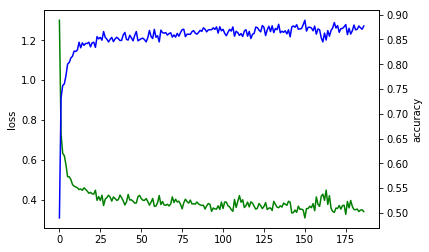

batch_size: 32 | learning_rate: 0.01 | loss_function: Cross Entropy | optimizer: Adam
Accuracy of the network on 10000 test images: 84.79%



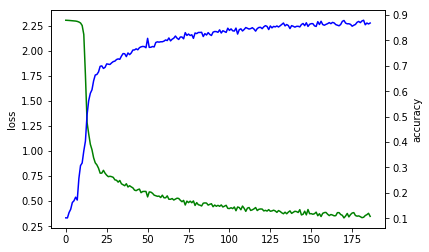

batch_size: 32 | learning_rate: 0.01 | loss_function: Cross Entropy | optimizer: SGD
Accuracy of the network on 10000 test images: 86.31%



batch_size: 32 | learning_rate: 0.01 | loss_function: Multi Hinge | optimizer: Adam
Accuracy of the network on 10000 test images: 84.74%



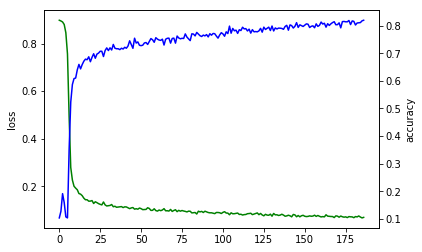

batch_size: 32 | learning_rate: 0.01 | loss_function: Multi Hinge | optimizer: SGD
Accuracy of the network on 10000 test images: 81.48%



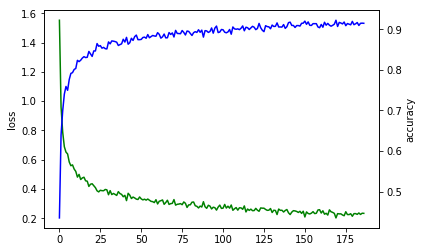

batch_size: 32 | learning_rate: 0.001 | loss_function: Cross Entropy | optimizer: Adam
Accuracy of the network on 10000 test images: 89.87%



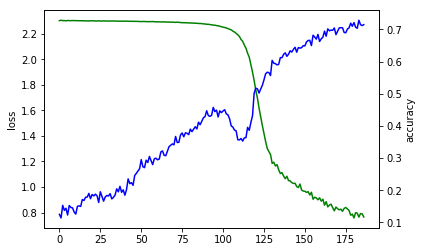

batch_size: 32 | learning_rate: 0.001 | loss_function: Cross Entropy | optimizer: SGD
Accuracy of the network on 10000 test images: 71.15%



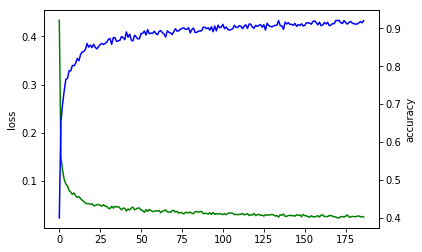

batch_size: 32 | learning_rate: 0.001 | loss_function: Multi Hinge | optimizer: Adam
Accuracy of the network on 10000 test images: 90.09%



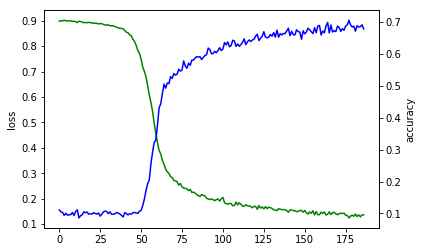

batch_size: 32 | learning_rate: 0.001 | loss_function: Multi Hinge | optimizer: SGD
Accuracy of the network on 10000 test images: 68.52%



In [0]:
batchs = [128, 32]
lrs = [0.01, 0.001]
# nn.MultiMarginLoss() is a multi-class classification hinge loss
loss_fns = [nn.CrossEntropyLoss(), nn.MultiMarginLoss()]
optimizers = ['ADAM', 'SGD']
epochs = 10
p_itr = 100

# training per hyperparameters
for batch in batchs:
  train_loader = DataLoader(train_dataset, batch_size = batch, shuffle = True, num_workers=4)
  for lr in lrs:
    for loss_fn in loss_fns:
      for op in optimizers:
        model = LeNet5(num_classes)
        model = model.to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr) if op == 'SGD' else torch.optim.Adam(model.parameters(), lr=lr)
        
        # train
        total_loss, total_acc = 0,0
        loss_list =[]
        acc_list = []
        itr = 1
        model.train()
        for epoch in range(epochs):
          for samples, labels in train_loader:
            samples, labels = samples.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(samples)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_acc += accuracy(output, labels)
    
            # for plot the graph
            if itr%p_itr == 0:
              loss_list.append(total_loss/p_itr)
              acc_list.append(total_acc/p_itr)
              total_loss, total_acc = 0,0
            itr+=1
          
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(loss_list, label='loss', color = 'g')
        ax2.plot(acc_list, label='accuracy', color = 'b')
        ax1.set_ylabel('loss')
        ax2.set_ylabel('accuracy')
        plt.show()
        
        loss_name = 'Cross Entropy' if isinstance(loss_fn, nn.CrossEntropyLoss) else 'Multi Hinge'
        optim_name = 'SGD' if isinstance(optimizer, torch.optim.SGD) else 'Adam'
        print('batch_size: {} | learning_rate: {} | loss_function: {} | optimizer: {}'.format(batch, lr, loss_name, optim_name))
        
        # test
        model.eval()
        test_acc = 0.0
        for samples, labels in test_loader:
          with torch.no_grad():
            samples, labels = samples.to(device), labels.to(device)
            output = model(samples)
            test_acc += accuracy(output, labels)
        print('Accuracy of the network on {} test images: {}%'.format(len(test_dataset), round(test_acc.item()*100.0/len(test_loader),2)))
        print()

In [0]:
# Ensemble model
class LeNet5Ensemble(nn.Module):
    def __init__(self, num, num_classes, device):
        super(LeNet5Ensemble,self).__init__()
        # you should use nn.ModuleList
        self.models = nn.ModuleList([LeNet5(num_classes).to(device) for _ in range(num)])
        
    def forward(self, x):
        output = torch.zeros([x.size(0), num_classes]).to(device)
        for model in self.models:
            output += model(x)
        return output

In [0]:
# Five LeNet5 network ensemble, 
# used batch_size: 32, lr: 0.001, lr_scheduler: multistepLR, loss: CrossEntropy, Optimizer: Adam, 

num_models = 5

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=4)
ensemble_model = LeNet5Ensemble(num_models, num_classes, device)
ensemble_model = ensemble_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000,10000,15000], gamma=0.5)

total_loss, total_acc = 0,0
loss_list = []
acc_list = []

epochs = 10
itr = 1
p_itr = 1000

# start training
ensemble_model.train()
for epoch in range(epochs):
    for samples, labels in train_loader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = ensemble_model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(output, labels)
        scheduler.step()
    
        if itr%p_itr == 0:
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_acc/p_itr))
            loss_list.append(total_loss/p_itr)
            acc_list.append(total_acc/p_itr)
            total_loss, total_acc = 0,0
        itr+=1
      

[Epoch 1/10] Iteration 1000 -> Train Loss: 0.6074, Accuracy: 0.775
[Epoch 2/10] Iteration 2000 -> Train Loss: 0.3632, Accuracy: 0.867
[Epoch 2/10] Iteration 3000 -> Train Loss: 0.3189, Accuracy: 0.881
[Epoch 3/10] Iteration 4000 -> Train Loss: 0.2929, Accuracy: 0.890
[Epoch 3/10] Iteration 5000 -> Train Loss: 0.2720, Accuracy: 0.900
[Epoch 4/10] Iteration 6000 -> Train Loss: 0.2456, Accuracy: 0.909
[Epoch 4/10] Iteration 7000 -> Train Loss: 0.2259, Accuracy: 0.917
[Epoch 5/10] Iteration 8000 -> Train Loss: 0.2175, Accuracy: 0.919
[Epoch 5/10] Iteration 9000 -> Train Loss: 0.2126, Accuracy: 0.922
[Epoch 6/10] Iteration 10000 -> Train Loss: 0.2015, Accuracy: 0.925
[Epoch 6/10] Iteration 11000 -> Train Loss: 0.1824, Accuracy: 0.933
[Epoch 7/10] Iteration 12000 -> Train Loss: 0.1777, Accuracy: 0.935
[Epoch 7/10] Iteration 13000 -> Train Loss: 0.1719, Accuracy: 0.936
[Epoch 8/10] Iteration 14000 -> Train Loss: 0.1625, Accuracy: 0.940
[Epoch 8/10] Iteration 15000 -> Train Loss: 0.1639, Accur

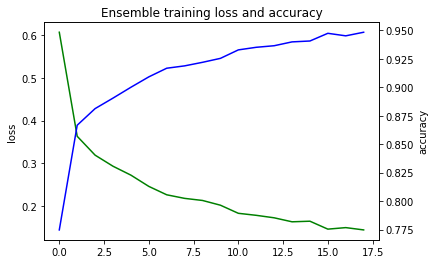

In [0]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(loss_list, label='ensemble_loss', color = 'g')
ax2.plot(acc_list, label='ensemble_accuracy', color = 'b')
ax1.set_ylabel('loss')
ax2.set_ylabel('accuracy')

plt.title('Ensemble training loss and accuracy')
plt.show()

In [0]:
# test 

ensemble_model.eval()
test_acc = 0.0
for samples, labels in test_loader:
    with torch.no_grad():
        samples, labels = samples.to(device), labels.to(device)
        output = ensemble_model(samples)
        test_acc += accuracy(output, labels)

print('Accuracy of the network on {} test images: {}%'.format(len(test_dataset), round(test_acc.item()*100.0/len(test_loader), 2)))

Accuracy of the network on 10000 test images: 91.74%
